# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at 

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [0]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

In [0]:
df = pd.read_csv("coronavirus_timeseries.csv")
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

In [3]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2015


## Forecasting in Antwerp

In [4]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
#antwerp_df.tail()
print(len(antwerp_df))

96


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
          "beta":0.899, "additional_features":["weekday","month"]}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'new_cases']][1:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'new_cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, Y_train = create_dataset(x_train_full, y_train_full, config_default["seq_len"])
X_test, y_test = create_dataset(test, test, config_default["seq_len"])

In [7]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.0015, 0.002, 0.003, 0.004, 0.01]
        } 
    }
}
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

Create sweep with ID: wr9ke1l2
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/wr9ke1l2


In [0]:
import matplotlib.pyplot as plt
def train():
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, r)
  evaluate_plot_multi(model, test, config, X_test, r_test)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_df, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  large_mse = tf.keras.losses.MSE(
    scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


In [19]:
wandb.agent(sweep_id, function=train)
#train()

wandb: Agent Starting Run: u33yh8mt with config:
	batch_size: 2
	learn: 0.004
wandb: Agent Started Run: u33yh8mt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 30ms/step - loss: 0.3278 - val_loss: 1.4238
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.3808 - val_loss: 5.9648
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 0.4778 - val_loss: 2.5174
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.1970 - val_loss: 3.3099
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.6696 - val_loss: 6.0359
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u33yh8mt 

wandb: Agent Starting Run: bj9t0goq with config:
	batch_size: 2
	learn: 0.01
wandb: Agent Started Run: bj9t0goq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 30ms/step - loss: 0.3543 - val_loss: 1.0730
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.5951 - val_loss: 1.4109
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 0.2207 - val_loss: 1.0879
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.2546 - val_loss: 3.8373
Epoch 5/30
28/28 [==============================] - 0s 9ms/step - loss: 0.5179 - val_loss: 7.5307
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bj9t0goq 

wandb: Agent Starting Run: delu7vhn with config:
	batch_size: 3
	learn: 0.001
wandb: Agent Started Run: delu7vhn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 41ms/step - loss: 1.1287 - val_loss: 8.0629
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 0.2785 - val_loss: 1.1660
Epoch 3/30
19/19 [==============================] - 0s 7ms/step - loss: 0.2821 - val_loss: 2.4080
Epoch 4/30
19/19 [==============================] - 0s 7ms/step - loss: 0.2845 - val_loss: 1.6744
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.1416 - val_loss: 2.7434
Epoch 6/30
19/19 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: delu7vhn 

wandb: Agent Starting Run: lx2vriyn with config:
	batch_size: 3
	learn: 0.0015
wandb: Agent Started Run: lx2vriyn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 42ms/step - loss: 0.8483 - val_loss: 4.4527
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 0.1944 - val_loss: 1.5968
Epoch 3/30
19/19 [==============================] - 0s 8ms/step - loss: 0.2106 - val_loss: 2.4833
Epoch 4/30
19/19 [==============================] - 0s 7ms/step - loss: 0.3286 - val_loss: 4.0059
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.2574 - val_loss: 3.3205
Epoch 6/30
19/19 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lx2vriyn 

wandb: Agent Starting Run: 4hku8e3i with config:
	batch_size: 3
	learn: 0.002
wandb: Agent Started Run: 4hku8e3i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 42ms/step - loss: 0.5665 - val_loss: 1.2880
Epoch 2/30
19/19 [==============================] - 0s 7ms/step - loss: 0.4381 - val_loss: 2.4584
Epoch 3/30
19/19 [==============================] - 0s 7ms/step - loss: 1.1542 - val_loss: 6.1686
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 0.3362 - val_loss: 1.2186
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.3513 - val_loss: 1.7094
Epoch 6/30
19/19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4hku8e3i 

wandb: Agent Starting Run: cmnpbbao with config:
	batch_size: 3
	learn: 0.003
wandb: Agent Started Run: cmnpbbao


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 41ms/step - loss: 0.2693 - val_loss: 3.3635
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 1.0388 - val_loss: 2.7905
Epoch 3/30
19/19 [==============================] - 0s 9ms/step - loss: 0.3590 - val_loss: 1.5148
Epoch 4/30
19/19 [==============================] - 0s 10ms/step - loss: 1.2042 - val_loss: 1.4703
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 1.3037 - val_loss: 9.1854
Epoch 6/30
19/19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cmnpbbao 

wandb: Agent Starting Run: qaog2hsf with config:
	batch_size: 3
	learn: 0.004
wandb: Agent Started Run: qaog2hsf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 41ms/step - loss: 0.2395 - val_loss: 1.4781
Epoch 2/30
19/19 [==============================] - 0s 8ms/step - loss: 0.6129 - val_loss: 3.0991
Epoch 3/30
19/19 [==============================] - 0s 9ms/step - loss: 0.6777 - val_loss: 1.1703
Epoch 4/30
19/19 [==============================] - 0s 8ms/step - loss: 1.3724 - val_loss: 10.2640
Epoch 5/30
19/19 [==============================] - 0s 9ms/step - loss: 0.4791 - val_loss: 1.7233
Epoch 6/30
19/19

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qaog2hsf 

wandb: Agent Starting Run: duptwbki with config:
	batch_size: 3
	learn: 0.01
wandb: Agent Started Run: duptwbki


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

19/19 [==============================] - 1s 43ms/step - loss: 0.2015 - val_loss: 5.4888
Epoch 2/30
19/19 [==============================] - 0s 9ms/step - loss: 0.6910 - val_loss: 4.1745
Epoch 3/30
19/19 [==============================] - 0s 9ms/step - loss: 0.3735 - val_loss: 0.9214
Epoch 4/30
19/19 [==============================] - 0s 9ms/step - loss: 1.7683 - val_loss: 1.1684
Epoch 5/30
19/19 [==============================] - 0s 7ms/step - loss: 0.4040 - val_loss: 5.5003
Epoch 6/30
19/19 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: duptwbki 

wandb: Agent Starting Run: gy36nri0 with config:
	batch_size: 4
	learn: 0.001
wandb: Agent Started Run: gy36nri0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 53ms/step - loss: 0.9404 - val_loss: 8.8658
Epoch 2/30
14/14 [==============================] - 0s 10ms/step - loss: 0.3729 - val_loss: 2.1394
Epoch 3/30
14/14 [==============================] - 0s 11ms/step - loss: 0.1794 - val_loss: 2.0115
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 0.2050 - val_loss: 2.2766
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.1689 - val_loss: 2.9002
Epoch 6/30
14/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gy36nri0 

wandb: Agent Starting Run: zy7hknm1 with config:
	batch_size: 4
	learn: 0.0015
wandb: Agent Started Run: zy7hknm1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 54ms/step - loss: 0.7442 - val_loss: 5.5942
Epoch 2/30
14/14 [==============================] - 0s 10ms/step - loss: 0.1975 - val_loss: 1.8293
Epoch 3/30
14/14 [==============================] - 0s 8ms/step - loss: 0.2240 - val_loss: 3.5854
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 0.2734 - val_loss: 2.0237
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.1629 - val_loss: 3.6444
Epoch 6/30
14/14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zy7hknm1 

wandb: Agent Starting Run: 1r62sdd8 with config:
	batch_size: 4
	learn: 0.002
wandb: Agent Started Run: 1r62sdd8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 54ms/step - loss: 0.5977 - val_loss: 3.8420
Epoch 2/30
14/14 [==============================] - 0s 10ms/step - loss: 0.2374 - val_loss: 2.3811
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 0.3968 - val_loss: 2.0360
Epoch 4/30
14/14 [==============================] - 0s 9ms/step - loss: 0.1616 - val_loss: 2.2481
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.1678 - val_loss: 2.3288
Epoch 6/30
14/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1r62sdd8 

wandb: Agent Starting Run: db230yrs with config:
	batch_size: 4
	learn: 0.003
wandb: Agent Started Run: db230yrs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 57ms/step - loss: 0.4601 - val_loss: 1.6519
Epoch 2/30
14/14 [==============================] - 0s 9ms/step - loss: 0.5387 - val_loss: 2.8430
Epoch 3/30
14/14 [==============================] - 0s 8ms/step - loss: 1.2091 - val_loss: 12.2819
Epoch 4/30
14/14 [==============================] - 0s 9ms/step - loss: 0.6699 - val_loss: 5.7145
Epoch 5/30
14/14 [==============================] - 0s 13ms/step - loss: 0.2522 - val_loss: 1.4329
Epoch 6/30
14/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: db230yrs 

wandb: Agent Starting Run: 2zqknxp3 with config:
	batch_size: 4
	learn: 0.004
wandb: Agent Started Run: 2zqknxp3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 54ms/step - loss: 0.2184 - val_loss: 3.9073
Epoch 2/30
14/14 [==============================] - 0s 10ms/step - loss: 0.8295 - val_loss: 3.2717
Epoch 3/30
14/14 [==============================] - 0s 8ms/step - loss: 1.3000 - val_loss: 14.9642
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 0.6727 - val_loss: 6.0099
Epoch 5/30
14/14 [==============================] - 0s 11ms/step - loss: 0.2449 - val_loss: 1.2234
Epoch 6/30
14/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2zqknxp3 

wandb: Agent Starting Run: cfoqiz7p with config:
	batch_size: 4
	learn: 0.01
wandb: Agent Started Run: cfoqiz7p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

14/14 [==============================] - 1s 54ms/step - loss: 0.5207 - val_loss: 2.6388
Epoch 2/30
14/14 [==============================] - 0s 8ms/step - loss: 0.4701 - val_loss: 2.7450
Epoch 3/30
14/14 [==============================] - 0s 10ms/step - loss: 0.8807 - val_loss: 1.9031
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 1.0714 - val_loss: 10.6301
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.2280 - val_loss: 3.6709
Epoch 6/30
14/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cfoqiz7p 

wandb: Agent Starting Run: omh2ipql with config:
	batch_size: 5
	learn: 0.001
wandb: Agent Started Run: omh2ipql


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 67ms/step - loss: 0.9361 - val_loss: 14.7298
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 0.5332 - val_loss: 6.5864
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 0.2344 - val_loss: 1.7471
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 0.1797 - val_loss: 1.4233
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.1658 - val_loss: 1.3107
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: omh2ipql 

wandb: Agent Starting Run: 04f07ygp with config:
	batch_size: 5
	learn: 0.0015
wandb: Agent Started Run: 04f07ygp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 65ms/step - loss: 0.7412 - val_loss: 10.3257
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 0.2104 - val_loss: 1.5644
Epoch 3/30
11/11 [==============================] - 0s 8ms/step - loss: 0.2475 - val_loss: 1.9687
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 0.2228 - val_loss: 1.6042
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.1669 - val_loss: 1.1755
Epoch 6/30
11/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 04f07ygp 

wandb: Agent Starting Run: b4e0my1z with config:
	batch_size: 5
	learn: 0.002
wandb: Agent Started Run: b4e0my1z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 69ms/step - loss: 0.6676 - val_loss: 7.4518
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 0.1714 - val_loss: 1.3128
Epoch 3/30
11/11 [==============================] - 0s 8ms/step - loss: 0.2919 - val_loss: 3.1555
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 0.4718 - val_loss: 3.9303
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 0.3012 - val_loss: 2.1524
Epoch 6/30
11/11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b4e0my1z 

wandb: Agent Starting Run: 4rkd9ik5 with config:
	batch_size: 5
	learn: 0.003
wandb: Agent Started Run: 4rkd9ik5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 67ms/step - loss: 0.3785 - val_loss: 1.9747
Epoch 2/30
11/11 [==============================] - 0s 8ms/step - loss: 0.4089 - val_loss: 3.1078
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 0.7185 - val_loss: 8.9268
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 0.5374 - val_loss: 6.2729
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 0.2765 - val_loss: 2.6844
Epoch 6/30
11/11 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4rkd9ik5 

wandb: Agent Starting Run: ylcey6hh with config:
	batch_size: 5
	learn: 0.004
wandb: Agent Started Run: ylcey6hh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 65ms/step - loss: 0.3361 - val_loss: 1.3225
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 0.3535 - val_loss: 2.1306
Epoch 3/30
11/11 [==============================] - 0s 9ms/step - loss: 1.0301 - val_loss: 16.0047
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 0.5704 - val_loss: 6.8321
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 0.2138 - val_loss: 1.2487
Epoch 6/30
11/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ylcey6hh 

wandb: Agent Starting Run: bxoqxfl8 with config:
	batch_size: 5
	learn: 0.01
wandb: Agent Started Run: bxoqxfl8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 66ms/step - loss: 0.2129 - val_loss: 2.1111
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 0.5392 - val_loss: 2.2634
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 1.1196 - val_loss: 1.4064
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 0.7789 - val_loss: 11.6041
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 0.3985 - val_loss: 1.9234
Epoch 6/30
11/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bxoqxfl8 



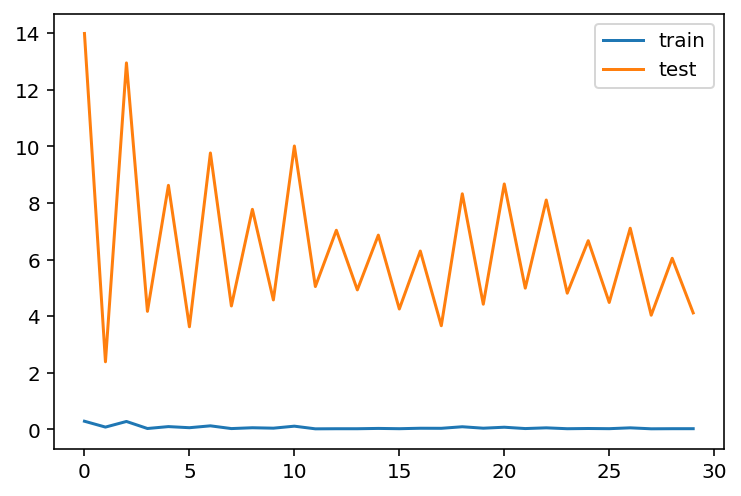

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models


In [0]:
import torch
import math
from torch.nn.modules import Transformer, TransformerEncoder, TransformerDecoder, TransformerDecoderLayer, TransformerEncoderLayer, LayerNorm
class CustomTransformerDecoder(torch.nn.Module):
    def __init__(self, seq_length, output_seq_length, n_time_series, d_model=128, output_dim=1):
        super().__init__()
        self.dense_shape = torch.nn.Linear(n_time_series, d_model)
        self.pe = SimplePositionalEncoding(d_model)
        encoder_layer = TransformerEncoderLayer(d_model, 8)
        encoder_norm = LayerNorm(d_model)
        self.transformer_enc = TransformerEncoder(encoder_layer, 6, encoder_norm)
        self.output_dim_layer = torch.nn.Linear(d_model, output_dim)
        self.output_seq_length = output_seq_length
        self.out_length_lay  = torch.nn.Linear(seq_length, output_seq_length)
        self.mask = generate_square_subsequent_mask(seq_length)
    def forward(self, x):
        """"""
        x = self.dense_shape(x)
        x = self.pe(x)
        x = x.permute(1,0,2)
        x = self.transformer_enc(x, mask=self.mask)
        x = self.output_dim_layer(x)
        x = x.permute(1, 2, 0)
        x = self.out_length_lay(x)
        return x.view(-1, self.output_seq_length)
    
class SimplePositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(SimplePositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x:torch.Tensor)->torch.Tensor:
        """Creates a basic positional encoding"""
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
        
def generate_square_subsequent_mask(sz:int)->torch.Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [0]:
c = CustomTransformerDecoder(50, 1, 3)

In [0]:
c(torch.rand(2, 50, 3))

tensor([[-0.2974],
        [-0.2575]], grad_fn=<ViewBackward>)

In [0]:
import torch

class LSTMForecast(torch.nn.Module):
    """
    A very simple baseline LSTM model that returns
    an output sequence given a multi-dimensional input seq. Inspired by the StackOverflow link below.
    https://stackoverflow.com/questions/56858924/multivariate-input-lstm-in-pytorch
    """
    def __init__(self, seq_length: int, n_time_series: int, output_seq_len=1, hidden_states:int=20, num_layers=2, bias=True, batch_size=100):
        super().__init__()
        self.forecast_history = seq_length
        self.n_time_series = n_time_series
        self.hidden_dim = hidden_states
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(n_time_series, hidden_states, num_layers, bias, batch_first=True)
        self.final_layer = torch.nn.Linear(seq_length*hidden_states, output_seq_len)
        self.init_hidden(batch_size)
    
    def init_hidden(self, batch_size)->None:
        # This is what we'll initialise our hidden state
        self.hidden = (torch.zeros(self.num_layers, batch_size, self.hidden_dim), torch.zeros(self.num_layers, batch_size, self.hidden_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size()[0]
        self.init_hidden(batch_size)
        out_x, self.hidden = self.lstm(x, self.hidden)
        x = self.final_layer(out_x.contiguous().view(batch_size, -1))
        return x

In [0]:
m =LSTMForecast(20, 3, 1)
y_pred = m(torch.rand(1, 20, 3))


In [0]:
optimiser = torch.optim.Adam(m.parameters(), lr=.1)
loss_fn = torch.nn.MSELoss()
#####################
# Train model
#####################
loss = loss_fn(y_pred, torch.rand(3,1))
hist = loss.item()
optimiser.zero_grad()
loss.backward()
optimiser.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
